In [1]:
# If you haven't already installed the necessary packages, uncomment and run:
# !pip install numpy pandas matplotlib statsmodels scikit-learn keras tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import math


In [2]:
# Load your dataset (update the path if needed)
df = pd.read_csv(r"C:\Users\Trijal\Desktop\Paper_Crop_PRice\data\ind_crop_yield.csv")

# Select relevant columns and average yield per year
df = df[['Crop_Year', 'Crop', 'Yield']]
df = df.groupby('Crop_Year')['Yield'].mean().reset_index()

# Set Crop_Year as index
df.set_index('Crop_Year', inplace=True)

# Show data
df.head()


,Yield
Crop_Year,
1997,63.872577
1998,55.938462
1999,76.943722
2000,75.572901
2001,75.441594


C:\Users\Trijal\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Trijal\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Trijal\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Trijal\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Trijal\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA par

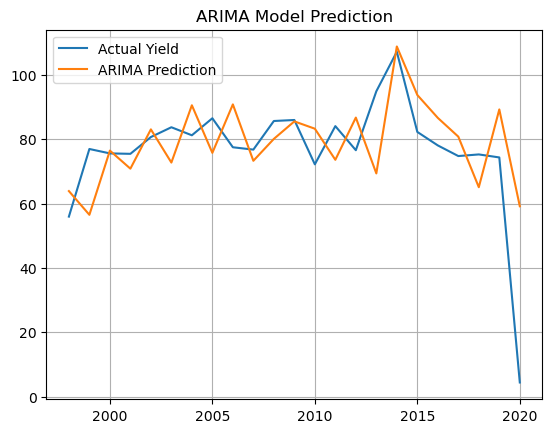

In [3]:
# Prepare time series data
ts = df['Yield']

# Fit ARIMA model
arima_model = ARIMA(ts, order=(2, 1, 2))  # (p,d,q) can be tuned
arima_result = arima_model.fit()

# Predict using ARIMA
arima_pred = arima_result.predict(start=1, end=len(ts)-1, typ='levels')

# Plot
plt.plot(ts[1:], label='Actual Yield')
plt.plot(arima_pred, label='ARIMA Prediction')
plt.legend()
plt.title('ARIMA Model Prediction')
plt.grid()
plt.show()


In [4]:
# Residuals = Actual - ARIMA predictions
residuals = ts[1:] - arima_pred

# Scale residuals
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Function to create sequences
def create_dataset(data, look_back=3):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Create sequences
look_back = 3
X, y = create_dataset(residuals_scaled, look_back)

# Reshape input for LSTM: [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [5]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X, y, epochs=100, batch_size=1, verbose=1)


C:\Users\Trijal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3728
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1191
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0274
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0435
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0262
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0556
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0278
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0350
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0612
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0324
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0435
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0557
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0433    
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0338    
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0

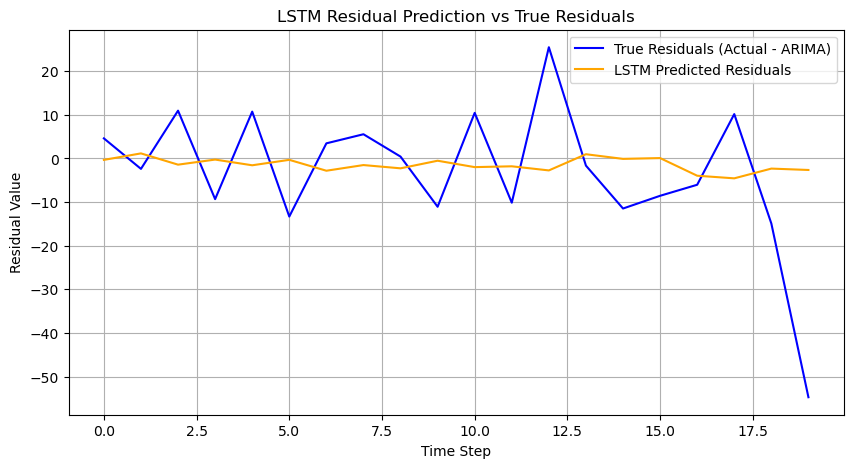

In [10]:
# Align true and predicted residuals
true_residuals = residuals[look_back:].values
lstm_pred_residuals = lstm_pred.flatten()

plt.figure(figsize=(10, 5))
plt.plot(true_residuals, label='True Residuals (Actual - ARIMA)', color='blue')
plt.plot(lstm_pred_residuals, label='LSTM Predicted Residuals', color='orange')
plt.title('LSTM Residual Prediction vs True Residuals')
plt.xlabel('Time Step')
plt.ylabel('Residual Value')
plt.legend()
plt.grid()
plt.show()


In [6]:
# Predict residuals using LSTM
lstm_pred_scaled = model.predict(X)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

# Combine ARIMA predictions with LSTM residual predictions
hybrid_pred = arima_pred[look_back:] + lstm_pred.flatten()

# Actual values to compare against
actual = ts[look_back+1:]

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(actual, hybrid_pred))
print(f'Hybrid Model RMSE: {rmse:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Hybrid Model RMSE: 16.0150


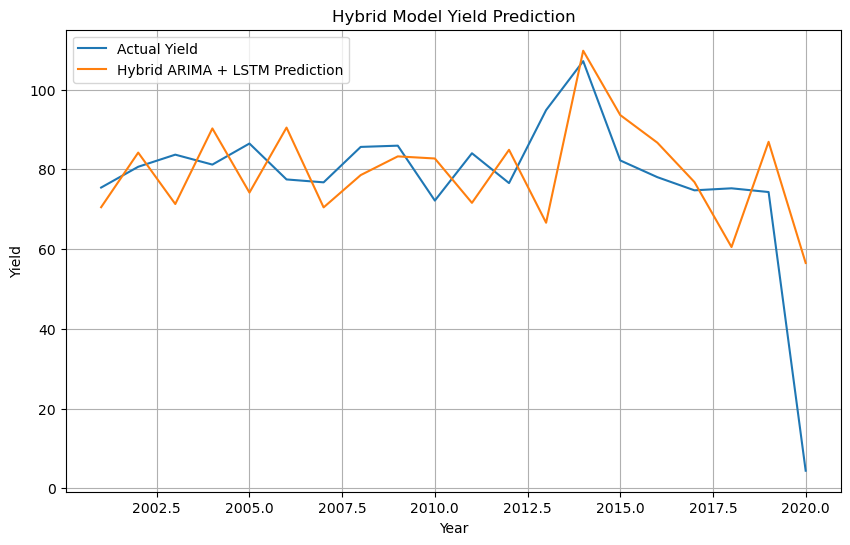

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(actual.index, actual, label='Actual Yield')
plt.plot(actual.index, hybrid_pred, label='Hybrid ARIMA + LSTM Prediction')
plt.title('Hybrid Model Yield Prediction')
plt.xlabel('Year')
plt.ylabel('Yield')
plt.legend()
plt.grid()
plt.show()


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ========== ARIMA ==========
actual_arima = ts[1:]
pred_arima = arima_pred

mae_arima = mean_absolute_error(actual_arima, pred_arima)
mse_arima = mean_squared_error(actual_arima, pred_arima)
rmse_arima = math.sqrt(mse_arima)
mape_arima = np.mean(np.abs((actual_arima - pred_arima) / actual_arima)) * 100
r2_arima = r2_score(actual_arima, pred_arima)

# ========== LSTM (Residual Prediction) ==========
true_residuals = residuals[look_back:].values
pred_residuals = lstm_pred.flatten()

mae_lstm = mean_absolute_error(true_residuals, pred_residuals)
mse_lstm = mean_squared_error(true_residuals, pred_residuals)
rmse_lstm = math.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((true_residuals - pred_residuals) / true_residuals)) * 100
r2_lstm = r2_score(true_residuals, pred_residuals)

# ========== Hybrid (ARIMA + LSTM) ==========
actual_hybrid = ts[look_back+1:]
pred_hybrid = hybrid_pred

mae_hybrid = mean_absolute_error(actual_hybrid, pred_hybrid)
mse_hybrid = mean_squared_error(actual_hybrid, pred_hybrid)
rmse_hybrid = math.sqrt(mse_hybrid)
mape_hybrid = np.mean(np.abs((actual_hybrid - pred_hybrid) / actual_hybrid)) * 100
r2_hybrid = r2_score(actual_hybrid, pred_hybrid)

# ========== Display All ==========
print("🔹 ARIMA Model Performance:")
print(f"MAE:  {mae_arima:.4f}")
print(f"MSE:  {mse_arima:.4f}")
print(f"RMSE: {rmse_arima:.4f}")
print(f"MAPE: {mape_arima:.2f}%")
print(f"R²:   {r2_arima:.4f}\n")

print("🔹 LSTM Residual Prediction Performance:")
print(f"MAE:  {mae_lstm:.4f}")
print(f"MSE:  {mse_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAPE: {mape_lstm:.2f}%")
print(f"R²:   {r2_lstm:.4f}\n")

print("🔹 Hybrid ARIMA + LSTM Model Performance:")
print(f"MAE:  {mae_hybrid:.4f}")
print(f"MSE:  {mse_hybrid:.4f}")
print(f"RMSE: {rmse_hybrid:.4f}")
print(f"MAPE: {mape_hybrid:.2f}%")
print(f"R²:   {r2_hybrid:.4f}")


🔹 ARIMA Model Performance:
MAE:  11.0760
MSE:  243.6347
RMSE: 15.6088
MAPE: 64.83%
R²:   0.2408

🔹 LSTM Residual Prediction Performance:
MAE:  11.7507
MSE:  256.4816
RMSE: 16.0150
MAPE: 136.73%
R²:   -0.0401

🔹 Hybrid ARIMA + LSTM Model Performance:
MAE:  11.7507
MSE:  256.4816
RMSE: 16.0150
MAPE: 70.15%
R²:   0.2589


 Interpretation Tips:
Lower MAE, MSE, RMSE, MAPE → better model.

R² closer to 1 → model explains most of the variance.

MAPE < 10% → considered excellent for many domains (though this can vary).